# <span style="color:#fcba03">Visualization of images</span>:

## <span style="color:#fcba03">DSC vs. INF TIME</span>:

### <span style="color:#f0baff">Imports and utility functions</span>:

In [2]:
import sys
sys.path.append('/home/si-hj/Desktop/medsegnet')
sys.path.append('/home/si-hj/Desktop')

import os
import time
from glob import glob
import ast

import matplotlib.pyplot as plt
import numpy as np

# Note: In this environment, torch may fail due to missing CUDA libraries.
# On your local machine with PyTorch installed, this will work fine.
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from omegaconf import OmegaConf
import torch.nn.functional as F
import torchio as tio
import json
# ------------------- Import your classes -------------------
# Use the correct path here. Previously you had `from models.Backbone` which was wrong.
from models.UNet import UNet3D
from models.UNetAug import UNetAugmented
from models.MSUNet import MSUNet3D
from medsegnet.utils.utils import setup_seed

from medsegnet.data.datasets import MedicalDecathlonDataset, ModalitiesDataset
from medsegnet.utils.metrics import dice_coefficient

# ------------------- Counting functions -------------------
def count_unet_params(model: UNet3D, scale: int = 0):
    """
    Count trainable parameters used by the base U-Net.

    Note: This intentionally excludes any multi-scale (MS) blocks or heads,
    since they are not part of the standard U-Net architecture.
    """
    modules = (
        list(model.encoders)
        + list(model.pools)
        + list(model.enc_dropouts)
        + [model.bn]
        + list(model.up_convs)
        + list(model.decoders)
        + list(model.dec_dropouts)
        + [model.final_conv]
    )
    return sum(p.numel() for m in modules for p in m.parameters() if p.requires_grad)

def count_msunet_params(model: MSUNet3D, scale: int):
    """
    Count trainable parameters actually used at a given MS-UNet scale.

    - scale == 0: Only the base U-Net parameters are counted; MS-specific
      blocks and heads are bypassed during inference at this scale, since they're not used.
    - scale > 0: Includes the base U-Net plus the multi-scale block and head
      corresponding to the requested scale, along with downstream layers.
    """
    assert 0 <= scale <= model.n_ms_levels < model.depth, "Scale out of bounds"
    if scale == 0:
        return count_unet_params(model)
    modules = []
    modules += [model.msb_blocks[scale - 1]]
    modules += [model.pools[scale], model.enc_dropouts[scale]]
    modules += (
        list(model.encoders)[scale + 1:]
        + list(model.pools)[scale + 1:]
        + list(model.enc_dropouts)[scale + 1:]
    )
    modules += [model.bn]
    num_ups = model.depth - scale
    modules += (
        list(model.up_convs)[:num_ups]
        + list(model.decoders)[:num_ups]
        + list(model.dec_dropouts)[:num_ups]
        + [model.ms_heads[scale - 1]]
    )
    return sum(p.numel() for m in modules for p in m.parameters() if p.requires_grad)

count_params_funcs = {
    "U-Net"   : count_unet_params,
    "U-Net+Aug": count_unet_params,
    "RARE-UNet" : count_msunet_params,
}

def create_trained_model(name, best_model_path, device, cfg, **kwargs):
    kwargs["mode"] = "inference"
    cls = {
        "U-Net": UNet3D,
        "U-Net+Aug": UNetAugmented,
        "RARE-UNet": MSUNet3D
    }.get(name)
    if cls is None:
        raise ValueError(f"Unknown model name: {name}")
    model = cls(cfg, **kwargs)
    state = torch.load(best_model_path, map_location=device)
    model.load_state_dict(state["model_state_dict"])
    return model

def create_test_dataset(cfg, image_dir, label_dir):
    img_files = [os.path.basename(p) for p in sorted(glob(os.path.join(image_dir, "*.nii*")))]
    lbl_files = [os.path.basename(p) for p in sorted(glob(os.path.join(label_dir, "*.nii*")))]
    cls = ModalitiesDataset if cfg.dataset.name == "Task01_BrainTumour" else MedicalDecathlonDataset
    return cls(cfg, "test", img_files, lbl_files, images_path=image_dir, masks_path=label_dir)


def align_pred_to_gt(pred, gt, encoding):
    """
    Align prediction to ground truth shape based on encoding.
    - If encoding is 'pad', crop/pad pred to gt shape using torchio.
    - Otherwise, downsample pred to gt shape using F.interpolate (nearest).
    """
    if encoding == "pad":
        # pred: (H, W, D) gt: (W, H, D)
        # Add channel if missing
        if pred.ndim == 3:
            pred = pred.unsqueeze(0)
        cp = tio.CropOrPad(gt.shape)
        pred_aligned = cp(pred.numpy())[0]  
        pred_aligned = torch.from_numpy(pred_aligned).type_as(pred)
        return pred_aligned
    else:
        # Downsample pred to gt shape using nearest neighbor
        pred = pred.unsqueeze(0).unsqueeze(0) if pred.ndim == 3 else pred.unsqueeze(0)
        pred_aligned = F.interpolate(pred.float(), size=gt.shape, mode="nearest")
        return pred_aligned.squeeze().type_as(pred)

### <span style="color:#f0baff">Paths</span>:

In [3]:
# =============================================================================
# 1) Define a top‐level dict mapping each dataset (or “task”) to its own settings
# =============================================================================



dataset_config = {
    # -----------------------------------------------------------------------------
    # Example entry for Task04_Hippocampus
    # -----------------------------------------------------------------------------
    "Task04_Hippocampus": {
       "model_paths": [
        	"/home/si-hj/Desktop/medsegnet/trained_models/unet3d/Task04_Hippocampus/2025-07-01_02:56:37_Hippo-Baseline-UNet", 
            "/home/si-hj/Desktop/medsegnet/trained_models/ms-unet3d/Task04_Hippocampus/2025-07-01_02:56:37_Hippo-RAREUNet-Final"
        ],
        "model_names": [
            "U-Net",
            "RARE-UNet", 
        ],
        "img_roots": [
            "/home/si-hj/Desktop/datasets/Task04_Hippocampus_test1/fullres",
            "/home/si-hj/Desktop/datasets/Task04_Hippocampus_test1/lowres"
        ],
        "lbl_roots": [
            "/home/si-hj/Desktop/datasets/Task04_Hippocampus_test1/lowres",
            "/home/si-hj/Desktop/datasets/Task04_Hippocampus_test1/lowres"
        ],
        "encodings_list": [
            # ["pad", "upsampled"],  
            ["upsampled"],
            ["downsampled"]
        ],
        "n_cls": 3,
        "scales": 4,
    },

    # -----------------------------------------------------------------------------
    # You can add more datasets/tasks here, each with its own n_cls, scales, etc.
    # -----------------------------------------------------------------------------
    "Task01_BrainTumour": {
        "model_paths": [
            "/home/si-hj/Desktop/medsegnet/trained_models/unet3d/Task01_BrainTumour/2025-07-01_02:56:40_Brats-Baseline-UNet",
            "/home/si-hj/Desktop/medsegnet/trained_models/ms-unet3d/Task01_BrainTumour/2025-07-01_02:56:40_Brats-RAREUNet-Final"    
        ],
        "model_names": [
            "U-Net", 
            "RARE-UNet"
        ],
        "img_roots": [
            "/home/si-hj/Desktop/datasets/Task01_BrainTumour_test1/fullres",
            "/home/si-hj/Desktop/datasets/Task01_BrainTumour_test1/lowres"
        ],
        "lbl_roots": [
            "/home/si-hj/Desktop/datasets/Task01_BrainTumour_test1/lowres",
            "/home/si-hj/Desktop/datasets/Task01_BrainTumour_test1/lowres"
        ],
        "encodings_list": [
            # ["pad", "upsampled"],
            ["upsampled"],
            ["downsampled"]
        ],
        "n_cls": 4,
        "scales": 4,
    },

    # ... add more entries as needed
}

# =============================================================================
# 2) Pick which dataset you want to use (e.g. via a variable `dataset_key`)
# =============================================================================
#dataset_key = "Task04_Hippocampus"
dataset_key = "Task01_BrainTumour"

# Make sure the key exists:
if dataset_key not in dataset_config:
    raise KeyError(f"Dataset '{dataset_key}' not found in dataset_config!")

cfg = dataset_config[dataset_key]

# -----------------------------------------------------------------------------
# 3) Extract variables from the chosen config
# -----------------------------------------------------------------------------
model_paths    = cfg["model_paths"]
model_names    = cfg["model_names"]
img_roots      = cfg["img_roots"]
lbl_roots      = cfg["lbl_roots"]
encodings_list = cfg["encodings_list"]
n_cls          = cfg["n_cls"]
scales         = cfg["scales"]

device = input("Enter device number (0 for cuda:0, 1 for cuda:1, etc., or leave empty for CPU): ").strip()
if device.isdigit():
    device = torch.device(f"cuda:{device}" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")
# =============================================================================
# 4) Rest of your code can simply refer to these variables now
# =============================================================================

# Example container for results:
results = []

# (Then later, you can loop over model_paths/model_names/etc.)
for model_path, model_name, encodings in zip(model_paths, model_names, encodings_list):
    print(f" -> Loading model '{model_name}' from {model_path}")
    print(f"    encodings = {encodings}")
    print(f"    n_cls     = {n_cls}, scales = {scales}")
    # …etc. load model, prepare dataloader, run inference, etc.


Using device: cuda:0
 -> Loading model 'U-Net' from /home/si-hj/Desktop/medsegnet/trained_models/unet3d/Task01_BrainTumour/2025-07-01_02:56:40_Brats-Baseline-UNet
    encodings = ['upsampled']
    n_cls     = 4, scales = 4
 -> Loading model 'RARE-UNet' from /home/si-hj/Desktop/medsegnet/trained_models/ms-unet3d/Task01_BrainTumour/2025-07-01_02:56:40_Brats-RAREUNet-Final
    encodings = ['downsampled']
    n_cls     = 4, scales = 4


### <span style="color:#f0baff">Computing results</span>:

In [4]:
#test with and iwthout setup see dand look at dixce
#Reset :) otherwise u end up with funky plots if u run this twice xD
results = []
setup_seed(42)
for model_path, model_name, img_root, lbl_root, encodings in zip(
    model_paths, model_names, img_roots, lbl_roots, encodings_list
):
    print(f"\n🔍 Evaluating model: {model_name}  @  {model_path}")
    cfg = OmegaConf.load(os.path.join(model_path, "config.yaml"))
    best_model_file = os.path.join(model_path, "best_model.pth")

    for enc in encodings:
        for scale in range(scales):
            img_dir = os.path.join(img_root, enc, f"scale{scale}", "imagesTs")
            lbl_dir = os.path.join(lbl_root, "downsampled", f"scale{scale}", "labelsTs") # Labels are always sampled from our lowres folder (in one of scales, scale0, scale1,)
            print(f"Label dir : {lbl_dir}")
            dataset = create_test_dataset(cfg, img_dir, lbl_dir)
            loader  = DataLoader(dataset, batch_size=1, shuffle=False)

            # Load and prepare model
            model = create_trained_model(model_name, best_model_file, device, cfg)
            model.to(device)
            model.eval()

            times, dice_scores = [], []
            for img, lbl in tqdm(loader, desc=f"{model_name} | {enc} | s{scale}"):
                img = img.to(device)
                with torch.no_grad():
                    t0  = time.time()
                    out = model(img)

                    pred = torch.argmax(out, dim=1).squeeze(0).cpu()
                    pred = align_pred_to_gt(pred, lbl.squeeze(0), enc)
                    t1  = time.time()
                gt   = lbl.squeeze(0)
                #print(f"  → Pred shape: {pred.shape}, dtype: {pred.dtype}")
                #print(f"  → GT shape: {gt.shape}, dtype: {gt.dtype}")

                dice = dice_coefficient(pred, gt, n_cls, ignore_index=0)

                times.append(t1 - t0)
                dice_scores.append(dice.item())

            param_count = count_params_funcs[model_name](model, scale)
            tqdm.write(f"  → Scale {scale}  params: {param_count:,}")

            print(np.mean(dice_scores), "±", float(np.std(dice_scores)))
            results.append({
                "model"    : model_name,
                "encoding" : enc,
                "scale"    : scale,
                "avg_time" : float(np.mean(times)),
                "avg_dice" : float(np.mean(dice_scores)),
                "params"   : param_count
            })
    
    
with open('/home/si-hj/Desktop/nn-unet/nnU-Net.json') as _f:
    data = json.load(_f)
    
dataset = data.get(dataset_key, None)
if dataset is None:
    print(f"Dataset {dataset_key} not found in nnU-Net data.")

params = dataset.get("params", -1)
print(f"Params for nnU-Net: {params:,}")

for enc in ['pad', "upsampled"]:
    for x in dataset[enc]:
        results.append({
            "model"    : "nnU-Net",
            "encoding" : enc,
            "scale"    : x['scale'],
            "avg_time" : x["avg_time"],
            "avg_dice" : x["avg_dice"],
            "params"   : params
        })
print(results)

INFO: training = True
INFO: depth = 5
INFO: target_shape = [256, 256, 128]
INFO: in_channels = 4
INFO: n_filters = 32
INFO: dropout = 0.1
INFO: num_classes = 4
INFO: norm_type = instance
INFO: activation_type = leaky_relu



🔍 Evaluating model: U-Net  @  /home/si-hj/Desktop/medsegnet/trained_models/unet3d/Task01_BrainTumour/2025-07-01_02:56:40_Brats-Baseline-UNet
Label dir : /home/si-hj/Desktop/datasets/Task01_BrainTumour_test1/lowres/downsampled/scale0/labelsTs


U-Net | upsampled | s0:   0%|          | 0/97 [00:00<?, ?it/s]/home/si-hj/.conda/envs/bp/lib/python3.10/site-packages/torchio/data/image.py:248: UserWarning: Using TorchIO images without a torchio.SubjectsLoader in PyTorch >= 2.3 might have unexpected consequences, e.g., the collated batches will be instances of torchio.Subject with 5D images. Replace your PyTorch DataLoader with a torchio.SubjectsLoader so that the collated batch becomes a dictionary, as expected. See https://github.com/TorchIO-project/torchio/issues/1179 for more context about this issue.
  warnings.warn(message, stacklevel=1)
U-Net | upsampled | s0: 100%|██████████| 97/97 [02:58<00:00,  1.84s/it]
INFO: training = True
INFO: depth = 5
INFO: target_shape = [256, 256, 128]
INFO: in_channels = 4
INFO: n_filters = 32
INFO: dropout = 0.1
INFO: num_classes = 4
INFO: norm_type = instance
INFO: activation_type = leaky_relu


  → Scale 0  params: 30,398,660
0.6992404039987584 ± 0.15395930817564127
Label dir : /home/si-hj/Desktop/datasets/Task01_BrainTumour_test1/lowres/downsampled/scale1/labelsTs


U-Net | upsampled | s1: 100%|██████████| 97/97 [02:42<00:00,  1.67s/it]
INFO: training = True
INFO: depth = 5
INFO: target_shape = [256, 256, 128]
INFO: in_channels = 4
INFO: n_filters = 32
INFO: dropout = 0.1
INFO: num_classes = 4
INFO: norm_type = instance
INFO: activation_type = leaky_relu


  → Scale 1  params: 30,398,660
0.6773078665905392 ± 0.15133763051532528
Label dir : /home/si-hj/Desktop/datasets/Task01_BrainTumour_test1/lowres/downsampled/scale2/labelsTs


U-Net | upsampled | s2: 100%|██████████| 97/97 [02:41<00:00,  1.66s/it]
INFO: training = True
INFO: depth = 5
INFO: target_shape = [256, 256, 128]
INFO: in_channels = 4
INFO: n_filters = 32
INFO: dropout = 0.1
INFO: num_classes = 4
INFO: norm_type = instance
INFO: activation_type = leaky_relu


  → Scale 2  params: 30,398,660
0.6202398254392073 ± 0.13319233839650468
Label dir : /home/si-hj/Desktop/datasets/Task01_BrainTumour_test1/lowres/downsampled/scale3/labelsTs


U-Net | upsampled | s3: 100%|██████████| 97/97 [02:38<00:00,  1.63s/it]
INFO: training = True
INFO: depth = 5
INFO: target_shape = [256, 256, 128]
INFO: in_channels = 4
INFO: n_filters = 32
INFO: dropout = 0.1
INFO: num_classes = 4
INFO: norm_type = instance
INFO: activation_type = leaky_relu


  → Scale 3  params: 30,398,660
0.49293565873018247 ± 0.13382000533610147

🔍 Evaluating model: RARE-UNet  @  /home/si-hj/Desktop/medsegnet/trained_models/ms-unet3d/Task01_BrainTumour/2025-07-01_02:56:40_Brats-RAREUNet-Final
Label dir : /home/si-hj/Desktop/datasets/Task01_BrainTumour_test1/lowres/downsampled/scale0/labelsTs
MSUNet3D: MODE=inference


RARE-UNet | downsampled | s0: 100%|██████████| 97/97 [02:56<00:00,  1.82s/it]
INFO: training = True
INFO: depth = 5
INFO: target_shape = [256, 256, 128]
INFO: in_channels = 4
INFO: n_filters = 32
INFO: dropout = 0.1
INFO: num_classes = 4
INFO: norm_type = instance
INFO: activation_type = leaky_relu


  → Scale 0  params: 30,398,660
0.6932452093694628 ± 0.1592992735017938
Label dir : /home/si-hj/Desktop/datasets/Task01_BrainTumour_test1/lowres/downsampled/scale1/labelsTs
MSUNet3D: MODE=inference


RARE-UNet | downsampled | s1: 100%|██████████| 97/97 [00:22<00:00,  4.38it/s]
INFO: training = True
INFO: depth = 5
INFO: target_shape = [256, 256, 128]
INFO: in_channels = 4
INFO: n_filters = 32
INFO: dropout = 0.1
INFO: num_classes = 4
INFO: norm_type = instance
INFO: activation_type = leaky_relu


  → Scale 1  params: 30,429,956
0.6933875093140554 ± 0.15417473374110077
Label dir : /home/si-hj/Desktop/datasets/Task01_BrainTumour_test1/lowres/downsampled/scale2/labelsTs
MSUNet3D: MODE=inference


RARE-UNet | downsampled | s2: 100%|██████████| 97/97 [00:05<00:00, 19.33it/s]
INFO: training = True
INFO: depth = 5
INFO: target_shape = [256, 256, 128]
INFO: in_channels = 4
INFO: n_filters = 32
INFO: dropout = 0.1
INFO: num_classes = 4
INFO: norm_type = instance
INFO: activation_type = leaky_relu


  → Scale 2  params: 30,326,276
0.651702951217435 ± 0.13836266780791745
Label dir : /home/si-hj/Desktop/datasets/Task01_BrainTumour_test1/lowres/downsampled/scale3/labelsTs
MSUNet3D: MODE=inference


RARE-UNet | downsampled | s3: 100%|██████████| 97/97 [00:02<00:00, 38.57it/s]

  → Scale 3  params: 29,897,732
0.5669396106422562 ± 0.16157900265600242
Params for nnU-Net: 30,790,196
[{'model': 'U-Net', 'encoding': 'upsampled', 'scale': 0, 'avg_time': 0.19664854118504474, 'avg_dice': 0.6992404039987584, 'params': 30398660}, {'model': 'U-Net', 'encoding': 'upsampled', 'scale': 1, 'avg_time': 0.17461818026513168, 'avg_dice': 0.6773078665905392, 'params': 30398660}, {'model': 'U-Net', 'encoding': 'upsampled', 'scale': 2, 'avg_time': 0.17290799396554218, 'avg_dice': 0.6202398254392073, 'params': 30398660}, {'model': 'U-Net', 'encoding': 'upsampled', 'scale': 3, 'avg_time': 0.163557158303015, 'avg_dice': 0.49293565873018247, 'params': 30398660}, {'model': 'RARE-UNet', 'encoding': 'downsampled', 'scale': 0, 'avg_time': 0.20352246343475028, 'avg_dice': 0.6932452093694628, 'params': 30398660}, {'model': 'RARE-UNet', 'encoding': 'downsampled', 'scale': 1, 'avg_time': 0.046550949824225044, 'avg_dice': 0.6933875093140554, 'params': 30429956}, {'model': 'RARE-UNet', 'encodin

### <span style="color:#f0baff">Plotting</span>:

#### 1st experiment: Both padding and upsampling

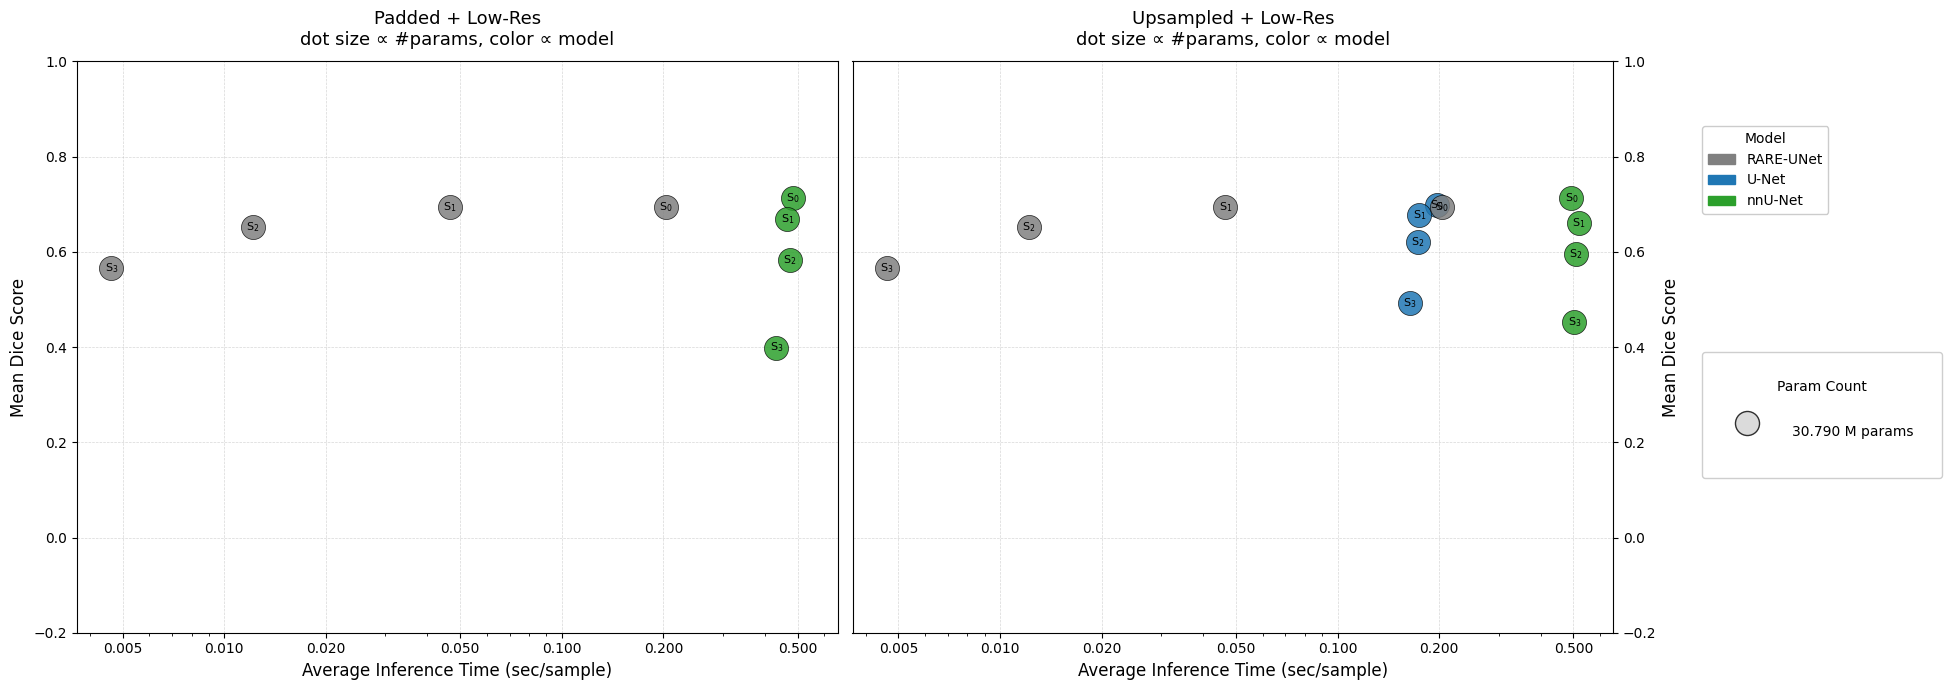

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from matplotlib.ticker import LogLocator, ScalarFormatter

# -------------------- Colors --------------------
color_map = {
    "nnU-Net":     "#2ca02c",
    "U-Net":       "tab:blue",
    "Proposed Model":    "tab:red"
}

np.random.seed(42)

# -------------------- Dot Size Scaling --------------------
# Include latest `params` value if it exists
param_list = [r["params"] for r in results if r["model"] == "Proposed Model"]
if 'params' in locals():
    param_list.append(params)

if param_list:
    min_param, max_param = min(param_list), max(param_list)
else:
    min_param, max_param = 1, 1  # fallback to prevent div-by-zero

def get_dot_size(p):
    """Map parameter count to a scatter‐point size."""
    if max_param == min_param:
        return 300
    norm = (p - min_param) / (max_param - min_param)
    return min(300 * (2.0 ** (norm * 2)), 1500)

# -------------------- Create Subplots --------------------
fig, (ax_pad, ax_upsample) = plt.subplots(1, 2, figsize=(20, 7), sharex=True, sharey=True)
plt.subplots_adjust(left=0.05, right=0.85, bottom=0.1, top=0.9, wspace=0.3)

# -------------------- Plotting Function --------------------
def plot_for_encodings(ax, encodings_to_plot, subplot_title):
    for r in results:
        if r["encoding"] not in encodings_to_plot:
            continue
        x, y = r["avg_time"], r["avg_dice"]
        p, m, s = r["params"], r["model"], r["scale"]

        z = 1 if p < 20e6 else 2 if p < 30e6 else 3
        ax.scatter(
            x, y,
            s=get_dot_size(p),
            facecolor=color_map.get(m, "gray"),
            edgecolor="k",
            linewidth=0.5,
            marker="o",
            alpha=0.85,
            zorder=z
        )
        ax.annotate(
            rf"$\mathsf{{S}}_{{{s}}}$",
            xy=(x, y),
            xytext=(0, 0),
            textcoords="offset points",
            fontsize=8,
            fontweight="bold",
            ha="center",
            va="center",
            zorder=z + 1
        )

    ax.set_xlabel("Average Inference Time (sec/sample)", fontsize=12)
    ax.set_ylabel("Mean Dice Score", fontsize=12)
    ax.set_title(f"{subplot_title}\n"
                 "dot size ∝ #params, color ∝ model",
                 pad=12, fontsize=13)
    ax.set_ylim(-0.2, 1.0)
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.5, zorder=-100)
    ax.set_facecolor("white")

# -------------------- Plot in Each Subplot --------------------
plot_for_encodings(ax_pad, {"downsampled", "pad"}, "Padded + Low-Res")
plot_for_encodings(ax_upsample, {"downsampled", "upsampled"}, "Upsampled + Low-Res")
    
ax_upsample.yaxis.tick_right()
ax_upsample.yaxis.set_label_position("right")
ax_upsample.tick_params(axis="y", labelleft=False, labelright=True)

from matplotlib.ticker import LogLocator, FixedLocator, FixedFormatter

# Set x-axis to log scale
for ax in (ax_pad, ax_upsample):
    ax.set_xscale("log")

    # Custom tick positions (you decide)
    ticks = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5]
    
    # LaTeX tick labels — math mode
    labels = [f"{t:.3f}" for t in ticks]
 
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, fontsize=10)



# -------------------- Param Count Legend --------------------
param_vals = sorted({r["params"] for r in results if r["model"] == "Proposed Model"} |
                    ({params} if 'params' in locals() else set()))

size_handles = [
    ax_pad.scatter([], [], s=get_dot_size(p),
                   facecolor="lightgray", edgecolor="k", alpha=0.8,
                   label=f"{p / 1e6:.3f} M params")
    for p in param_vals
]

fig.legend(
    handles=size_handles,
    title="Param Count",
    loc="center left",
    bbox_to_anchor=(0.85, 0.40),
    framealpha=0.95,
    labelspacing=1.5,
    handlelength=2.5,
    handleheight=3.5,
    handletextpad=2,
    borderpad=2,
    title_fontsize=10,
    fontsize=10
)

# -------------------- Model Legend --------------------
model_names = sorted({r["model"] for r in results})
color_handles = [
    mpatches.Patch(color=color_map.get(m, "gray"), label=m)
    for m in model_names
]
fig.legend(
    handles=color_handles,
    title="Model",
    loc="center left",
    bbox_to_anchor=(0.85, 0.75),
    framealpha=1.0,
    title_fontsize=10,
    fontsize=10
)
# -------------------- Final Touches --------------------
save = True
plt.tight_layout(rect=(0, 0, 0.85, 1))

if save:
    plt.savefig(
        "/home/si-hj/Desktop/inference/dice_vs_time_hp.svg",
        bbox_inches="tight", 
        dpi=300
    )
    
plt.show()


#### 2nd experiment: Only upsampling plots for paper and no titles

INFO: Setting global font to: /home/si-hj/Desktop/inference/fonts/times.ttf


INFO: maxp pruned
INFO: cmap pruned
INFO: kern dropped
INFO: post pruned
INFO: FFTM dropped
INFO: GPOS pruned
INFO: GSUB pruned
INFO: glyf pruned
INFO: Added gid0 to subset
INFO: Added first four glyphs to subset
INFO: Closing glyph list over 'MATH': 9 glyphs before
INFO: Glyph names: ['.notdef', '.null', 'S', 'nonmarkingreturn', 'one', 'space', 'three', 'two', 'zero']
INFO: Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 54]
INFO: Closed glyph list over 'MATH': 9 glyphs after
INFO: Glyph names: ['.notdef', '.null', 'S', 'nonmarkingreturn', 'one', 'space', 'three', 'two', 'zero']
INFO: Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 54]
INFO: Closing glyph list over 'GSUB': 9 glyphs before
INFO: Glyph names: ['.notdef', '.null', 'S', 'nonmarkingreturn', 'one', 'space', 'three', 'two', 'zero']
INFO: Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 54]
INFO: Closed glyph list over 'GSUB': 9 glyphs after
INFO: Glyph names: ['.notdef', '.null', 'S', 'nonmarkingreturn', 'one', 'space', 'three', 'two', 'zero']

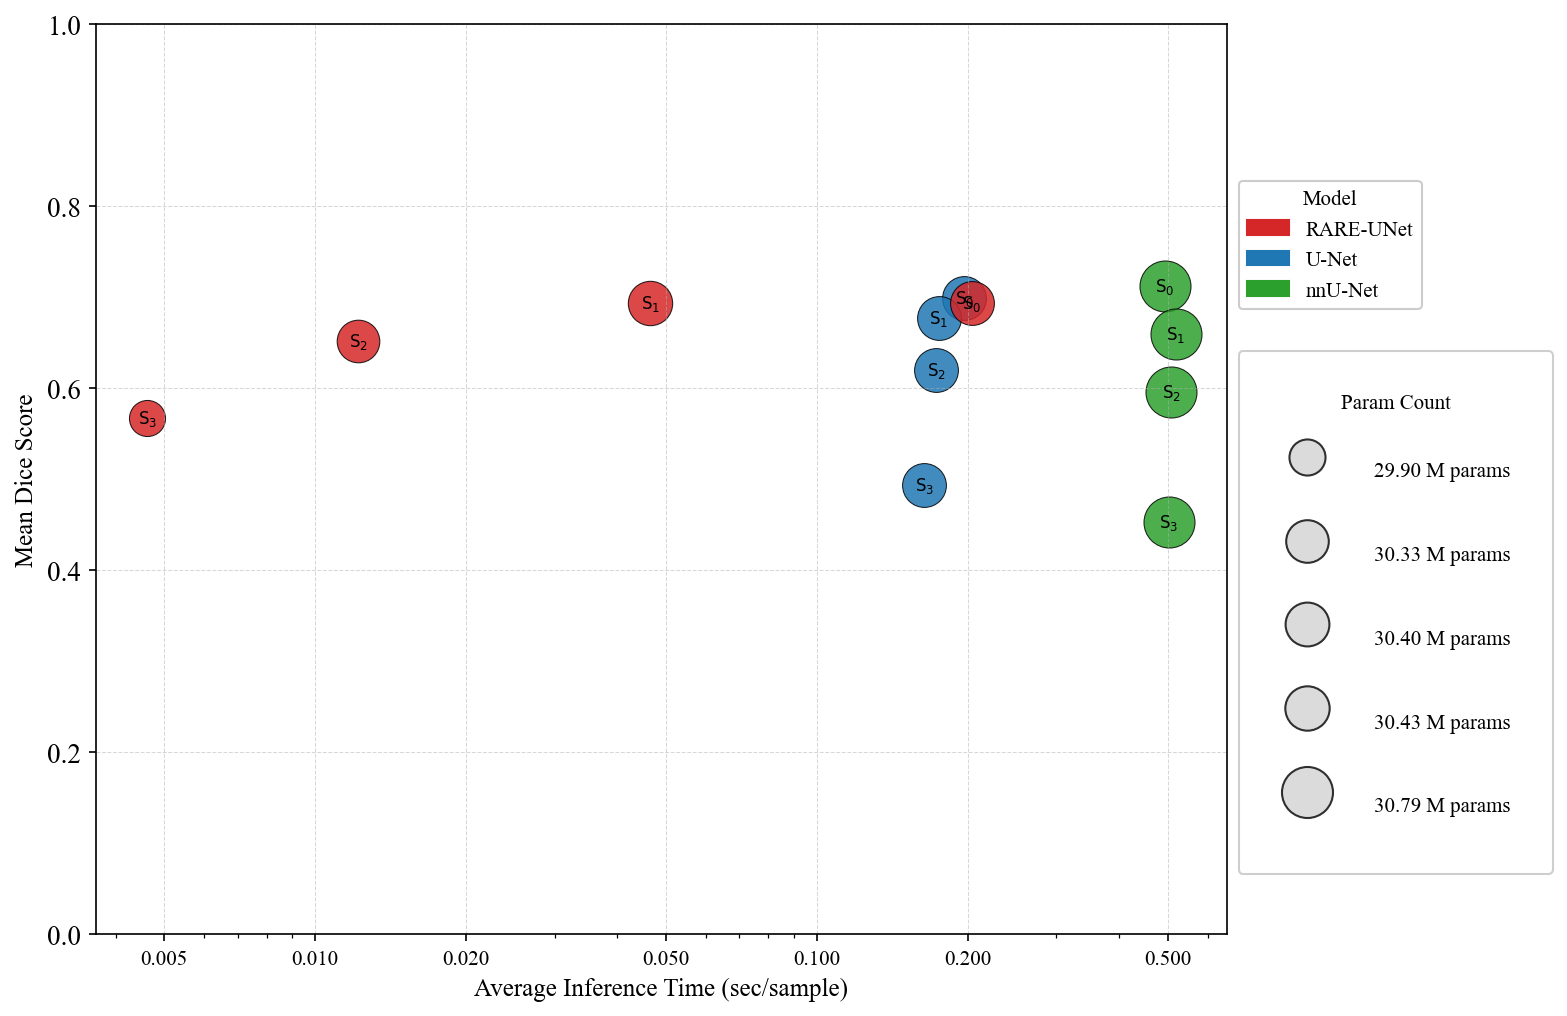

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from matplotlib.ticker import LogLocator, ScalarFormatter

from inference.utils import setup_font

# -------------------- Colors --------------------
color_map = {
    "nnU-Net":     "#2ca02c",
    "U-Net":       "tab:blue",
    "RARE-UNet":    "tab:red"
}

np.random.seed(42)
setup_font("/home/si-hj/Desktop/inference/fonts/times.ttf")
# -------------------- Dot Size Scaling --------------------
# Include latest `params` value if it exists
param_list = [r["params"] for r in results if r["model"] == "RARE-UNet"]
if 'params' in locals():
    param_list.append(params)

if param_list:
    min_param, max_param = min(param_list), max(param_list)
else:
    min_param, max_param = 1, 1  # fallback to prevent div-by-zero

def get_dot_size(p):
    """Map parameter count to a scatter‐point size."""
    if max_param == min_param:
        return 300
    norm = (p - min_param) / (max_param - min_param)
    return min(300 * (2.0 ** (norm * 1)), 1500)

# -------------------- Create Subplots --------------------
fig, ax = plt.subplots(figsize=(10, 7))
plt.subplots_adjust(left=0.1, right=0.8, bottom=0.1, top=0.9)

def plot_for_encodings(ax, encodings_to_plot):
    for r in results:
        if r["encoding"] not in encodings_to_plot:
            continue
        x, y = r["avg_time"], r["avg_dice"]
        p, m, s = r["params"], r["model"], r["scale"]

        ax.scatter(
            x, y,
            s=get_dot_size(p),
            facecolor=color_map.get(m, "gray"),
            edgecolor="k",
            linewidth=0.5,
            alpha=0.85
        )
        ax.annotate(
            rf"$\mathsf{{S}}_{{{s}}}$",
            xy=(x, y),
            xytext=(0, 0),
            textcoords="offset points",
            fontsize=8,
            fontweight="bold",
            ha="center",
            va="center"
        )

    ax.set_xlabel("Average Inference Time (sec/sample)", fontsize=12)
    ax.set_ylabel("Mean Dice Score", fontsize=12)
    ax.set_xscale("log")
    ax.set_ylim(0, 1.0)
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
    ax.set_facecolor("white")

    # Custom log‐ticks
    ticks = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5]
    ax.set_xticks(ticks)
    ax.set_xticklabels([f"{t:.3f}" for t in ticks], fontsize=10)


# -------------------- Call with your desired encoding set --------------------
plot_for_encodings(ax, {"downsampled", "upsampled"})


# -------------------- Param Count Legend --------------------
param_vals = sorted({r["params"] for r in results if r["model"] == "RARE-UNet"} |
                    ({params} if 'params' in locals() else set()))

size_handles = [
    ax.scatter([], [], s=get_dot_size(p),
                   facecolor="lightgray", edgecolor="k", alpha=0.8,
                   label=f"{p / 1e6:.2f} M params")
    for p in param_vals
]

fig.legend(
    handles=size_handles,
    title="Param Count",
    loc="center left",
    bbox_to_anchor=(0.83, 0.40),
    framealpha=0.95,
    labelspacing=1.5,
    handlelength=2.5,
    handleheight=3.5,
    handletextpad=2,
    borderpad=2,
    title_fontsize=10,
    fontsize=10
)

# -------------------- Model Legend --------------------
model_names = sorted({r["model"] for r in results})
color_handles = [
    mpatches.Patch(color=color_map.get(m, "gray"), label=m)
    for m in model_names
]
fig.legend(
    handles=color_handles,
    title="Model",
    loc="center left",
    bbox_to_anchor=(0.83, 0.75),
    framealpha=1.0,
    title_fontsize=10,
    fontsize=10
)
# -------------------- Final Touches --------------------
save = True
plt.tight_layout(rect=(0, 0, 0.85, 1))

if save:
    plt.savefig(
        f"/home/si-hj/Desktop/inference/figures/dice_vs_time/{dataset_key}.pdf",
        bbox_inches="tight", 
        dpi=300
    )
    
plt.show()


## <span style="color:#fcba03">Box plot over datasets</span>:

### <span style="color:#f0baff">Setup</span>:

In [7]:
# === Cell 1: Imports and configuration ===
import os
import glob

import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import font_manager as fm

# If you want inline figures in Jupyter:
%matplotlib inline

# Use your uploaded font
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import font_manager as fm

# 1. Load your custom TTF font
font_path = "/home/si-hj/Desktop/inference/fonts/times.ttf"
font_prop = fm.FontProperties(fname=font_path)
fm.fontManager.addfont(font_path)
mpl.rcParams['font.family'] = font_prop.get_name()

# Point to your folders here:
datasets_config = {
    "Task01_BrainTumour": {
        "image_dir": "/home/si-hj/Desktop/datasets/Task01_BrainTumour/imagesTr",
        "show_90th_percentile": False,
    },
    "Task04_Hippocampus": {
        "image_dir": "/home/si-hj/Desktop/datasets/Task04_Hippocampus/imagesTr",
        "show_90th_percentile": True,
    },
}


### <span style="color:#f0baff">Helper functions</span>:

In [8]:
# === Cell 2 (updated): Helper Functions with save‐to‐PDF/PNG ===

import os
import matplotlib as mpl

def nearest_power_of_two(value: float) -> int:
    """Return the nearest power of two to a positive value. If value ≤ 0, return 0."""
    if value <= 0:
        return 0
    return int(2 ** np.round(np.log2(value)))

def gather_nifti_shapes(image_folder: str) -> list:
    """
    Locate all .nii and .nii.gz files in image_folder,
    load each with nibabel, and return a list of their shape tuples.
    """
    patterns = ["*.nii", "*.nii.gz"]
    file_list = []
    for pat in patterns:
        file_list.extend(glob.glob(os.path.join(image_folder, pat)))
    file_list = sorted(file_list)

    if not file_list:
        raise FileNotFoundError(f"No NIfTI files found in {image_folder!r}")

    shapes = []
    for fpath in tqdm(file_list, desc=f"Loading NIfTIs in {os.path.basename(image_folder)}"):
        img = nib.load(fpath)
        shapes.append(img.header.get_data_shape())
    return shapes

def plot_dimension_boxplot(dims: list, show_90th_percentile:bool, percentiles_90:list, task_name: str, save_dir: str) -> None:
    """
    Given `dims` (a list where dims[i] is a list of all sizes along axis i),
    draw a boxplot for this task with paper‐ready styling, then save
    both PDF and PNG under `save_dir/`.
    """
    # 1) Tweak rcParams for larger fonts & thicker lines
    mpl.rcParams.update({
        "figure.dpi": 150,
        "font.size": 14,
        "axes.titlesize": 16,
        "axes.labelsize": 15,
        "xtick.labelsize": 13,
        "ytick.labelsize": 13,
        "legend.fontsize": 13,
        "lines.linewidth": 1.5,
        "boxplot.boxprops.linewidth": 1.5,
        "boxplot.whiskerprops.linewidth": 1.5,
        "boxplot.capprops.linewidth": 1.5,
        "boxplot.medianprops.linewidth": 2.0,
    })

    n_dim = len(dims)
    fig, ax = plt.subplots(figsize=(6, 4.5))

    # 2) Create the boxplot with light‐gray fill and black edges
    bp = ax.boxplot(
        dims,
        labels=[f"dim {i}" for i in range(1, n_dim + 1)],
        notch=False,
        patch_artist=True,
        medianprops=dict(color="black"),
        boxprops=dict(facecolor="#DDDDDD", edgecolor="black"),
        whiskerprops=dict(color="black"),
        capprops=dict(color="black"),
        flierprops=dict(marker="o", markerfacecolor="black", markersize=4, alpha=0.6),
    )

    # 3) Optionally overlay each point (small jitter) for distribution insight
    for i in range(n_dim):
        y = np.array(dims[i])
        x = np.random.normal(i + 1, 0.04, size=len(y))
        ax.scatter(x, y, alpha=0.4, s=8, color="black", linewidths=0)

    ax.set_ylabel("Size (pixels)", labelpad=10)
    # ax.set_title(f"Image Shape Distribution ({n_dim}D)\n{task_name}", pad=12)

    ax.grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)

    if show_90th_percentile:
        percentile_line_artist = None
        for i in range(n_dim):
            percentile_val = percentiles_90[i]
            xmin_line = (i + 1) - 0.20 
            xmax_line = (i + 1) + 0.20 
            line = ax.hlines(
                percentile_val,
                xmin=xmin_line,
                xmax=xmax_line,
                colors='red',
                linestyles='--',
                linewidth=2,
                label='90th Percentile' if i == 0 else ""
            )
            if i == 0:
                percentile_line_artist = line # Store the artist for the legend
            text_val_str = f"{percentile_val:.1f}" 
            ax.text(
                xmax_line + 0.03,  
                percentile_val,  
                text_val_str,      
                color='red',      
                fontsize=10,       
                va='center',      
                ha='left',       
                # Optional: Add a subtle background to the text for readability
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.15')
            )
        if percentile_line_artist:
            ax.legend(handles=[percentile_line_artist], loc='upper right')

    plt.tight_layout()

    # 4) Ensure save_dir exists, then write both PDF and PNG:
    os.makedirs(save_dir, exist_ok=True)
    base_fn = task_name.lower().replace(" ", "_") + "_dims"

    pdf_path = os.path.join(save_dir, f"{base_fn}.pdf")
    png_path = os.path.join(save_dir, f"{base_fn}.png")

    fig.savefig(pdf_path, format="pdf", bbox_inches="tight")
    fig.savefig(png_path, format="png", dpi=300, bbox_inches="tight")

    print(f"  → Saved: {pdf_path}")
    print(f"  → Saved: {png_path}")

    plt.show()
    plt.close()


### <span style="color:#f0baff">Plotting</span>:



=== Task01_BrainTumour ===


Loading NIfTIs in imagesTr:   0%|          | 0/484 [00:00<?, ?it/s]

Loading NIfTIs in imagesTr: 100%|██████████| 484/484 [00:00<00:00, 1548.79it/s]
/tmp/ipykernel_1892772/592707287.py:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


  → 90th percentile for dim 1: 240.0
  → 90th percentile for dim 2: 240.0
  → 90th percentile for dim 3: 155.0
  → 90th percentile for dim 4: 4.0
  → Nearest powers of two: [256, 256, 128, 4]
  → Saved: plots/boxplots/task01_braintumour/task01_braintumour_dims.pdf
  → Saved: plots/boxplots/task01_braintumour/task01_braintumour_dims.png


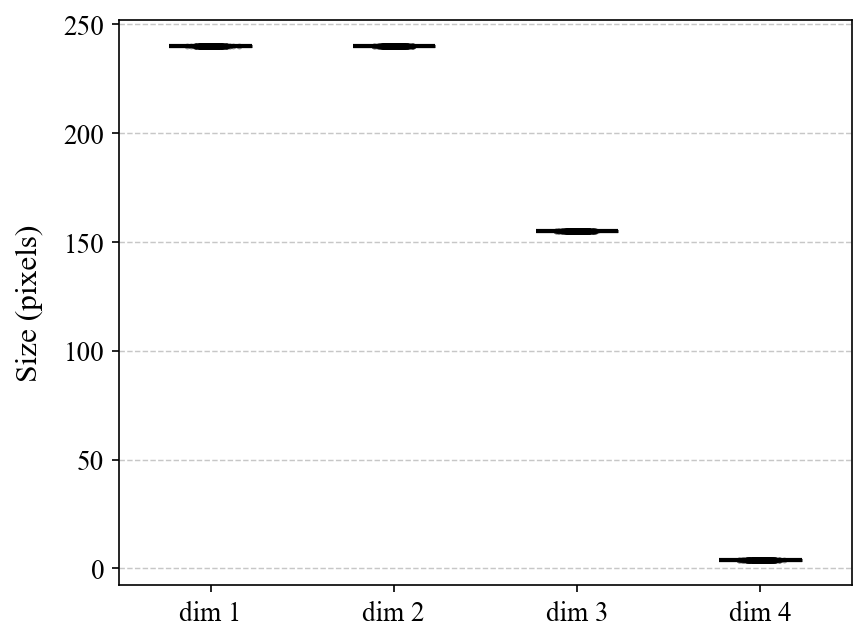


=== Task04_Hippocampus ===


Loading NIfTIs in imagesTr: 100%|██████████| 260/260 [00:00<00:00, 1525.73it/s]

  → 90th percentile for dim 1: 38.0
  → 90th percentile for dim 2: 54.0
  → 90th percentile for dim 3: 41.0
  → Nearest powers of two: [32, 64, 32]



/tmp/ipykernel_1892772/592707287.py:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


  → Saved: plots/boxplots/task04_hippocampus/task04_hippocampus_dims.pdf
  → Saved: plots/boxplots/task04_hippocampus/task04_hippocampus_dims.png


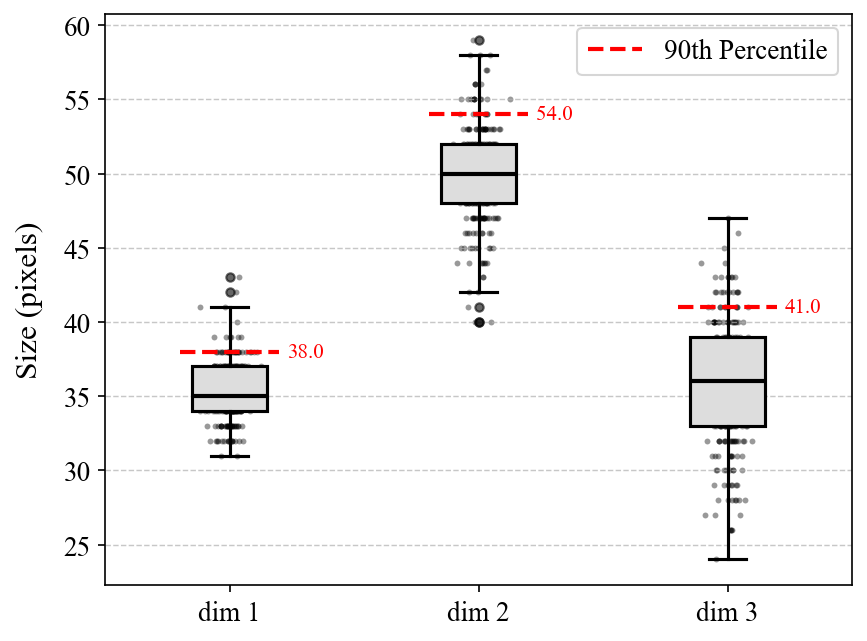

In [9]:
for task_name, cfg in datasets_config.items():
    img_dir = cfg["image_dir"]
    print(f"\n=== {task_name} ===")
    if not os.path.isdir(img_dir):
        print(f"  → ERROR: image_dir does not exist: {img_dir}")
        continue

    shapes = gather_nifti_shapes(img_dir)

    n_dim = len(shapes[0])
    if not all(len(s) == n_dim for s in shapes):
        raise RuntimeError("Not all NIfTIs have the same number of dimensions!")
    dims = [[] for _ in range(n_dim)]
    for shp in shapes:
        for axis_idx in range(n_dim):
            dims[axis_idx].append(shp[axis_idx])

    percentiles = []
    for axis_idx in range(n_dim):
        p90 = np.percentile(dims[axis_idx], 90)
        percentiles.append(p90)
        print(f"  → 90th percentile for dim {axis_idx + 1}: {p90:.1f}")

    pow2_dims = [nearest_power_of_two(p) for p in percentiles]
    print(f"  → Nearest powers of two: {pow2_dims}")

    save_folder = os.path.join("plots", "boxplots", task_name.lower().replace(" ", "_"))
    show_90th_percentile = cfg.get("show_90th_percentile", True)
    plot_dimension_boxplot(dims, show_90th_percentile, percentiles, task_name, save_folder)



tr architecture=ms-unet3d wandb.log=true architecture.depth=4 architecture.n_filters=64 architecture.dropout=0.1 training.loss.params.alpha=0 training.num_epochs=120 training.early_stopper.criterion=dice training.early_stopper.patience=30 gpu.devices=[2] wandb.name=ms_d4_w64_dropout0.1_a0 && \
tr architecture=bb-unet3d wandb.log=true architecture.depth=4 architecture.n_filters=64 architecture.dropout=0.1 training.loss.params.alpha=0 training.num_epochs=120 training.early_stopper.criterion=dice training.early_stopper.patience=30 gpu.devices=[2] wandb.name=bb_d4_w64_dropout0.1_a0 && \
tr architecture=bb-aug-unet3d wandb.log=true architecture.depth=4 architecture.n_filters=64 architecture.dropout=0.1 training.loss.params.alpha=0 training.num_epochs=120 training.early_stopper.criterion=dice training.early_stopper.patience=30 gpu.devices=[2] wandb.name=bb-aug_d4_w64_dropout0.1_a0

## Next shit?

(240, 240, 155, 4)
(1.0, 1.0, 1.0, 1.0)


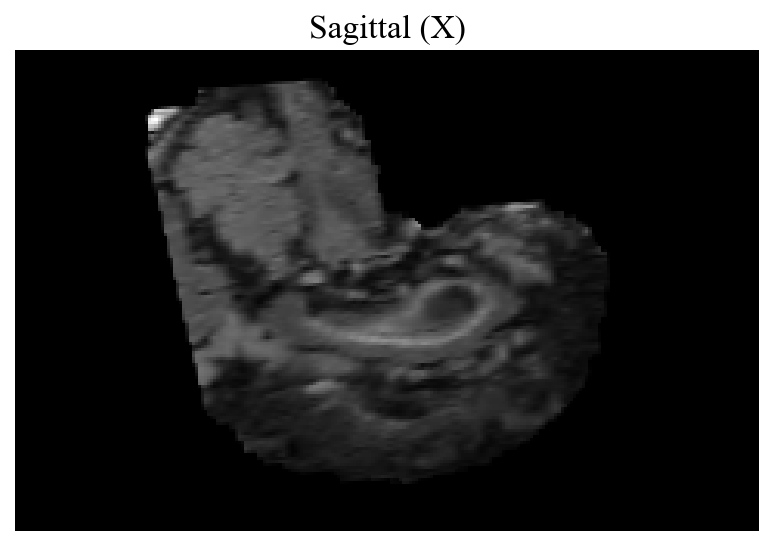

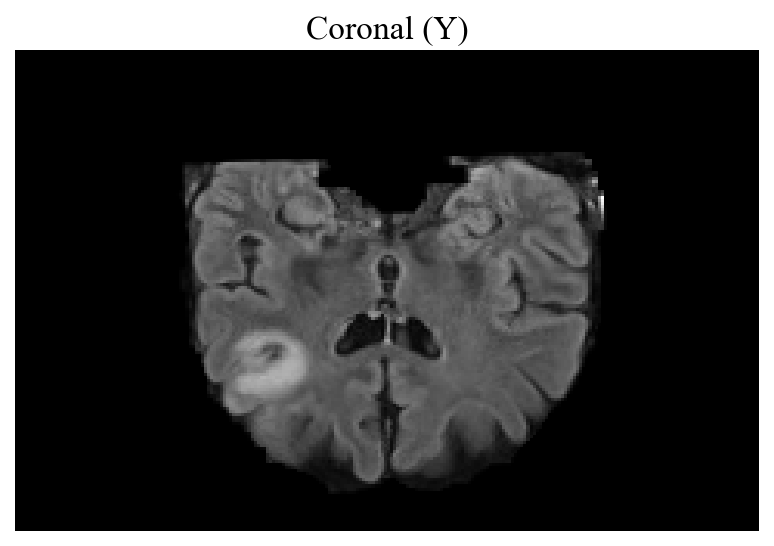

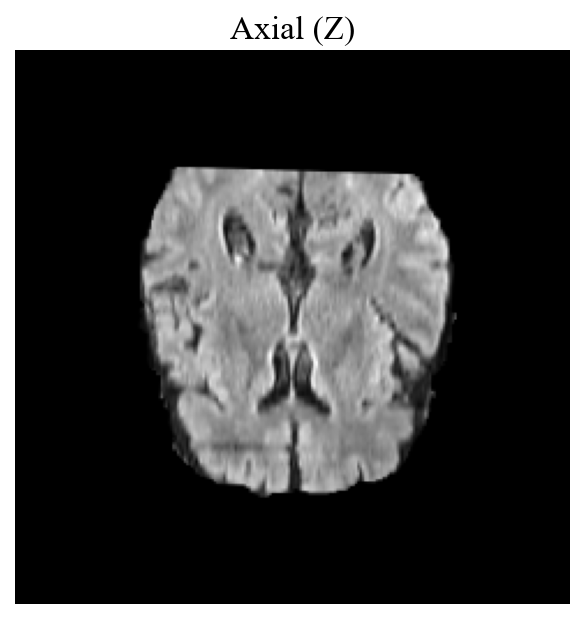

In [10]:
import nibabel as nib
import numpy as np

img = nib.load("../datasets/Task01_BrainTumour/imagesTr/BRATS_012.nii.gz")
print(img.header.get_data_shape())
print(img.header.get_zooms())
img = img.get_fdata()
img = np.moveaxis(img, -1, 0) 



import matplotlib.pyplot as plt
modalities = {
    'FLAIR': 0,
    'T1w': 1,
    'T1wCE': 2,
    'T2w': 3
}
mid_x = img.shape[1] // 2
mid_y = img.shape[2] // 2
mid_z = img.shape[3] // 2
mod_idx = modalities["T1w"]



m = modalities["FLAIR"]
sag = img[m, mid_x, :, :]
cor = img[m, :, mid_y, :]
axi = img[m, :, :, mid_z]

# rotate so that anterior–posterior runs left–right, and superior–inferior runs up–down
sag = np.rot90(sag)
cor = np.rot90(cor)
axi = np.rot90(axi)

for slc, title in zip((sag, cor, axi),
                      ("Sagittal (X)", "Coronal (Y)", "Axial (Z)")):
    plt.figure()
    plt.imshow(slc, cmap="gray", origin="lower")
    plt.title(title)
    plt.axis("off")
    plt.show()


In [11]:
import sys
sys.path.append('/home/si-hj/Desktop/medsegnet')
sys.path.append('/home/si-hj/Desktop')

from ast import mod
import pathlib
import numpy as np
from omegaconf import DictConfig, OmegaConf
from typing import Dict, Tuple
import torchio as tio
import torch
import matplotlib.pyplot as plt
import os
from data.datasets import MedicalDecathlonDataset, ModalitiesDataset
from utils.assertions import ensure
from pathlib import Path
from time import time
import nibabel as nib
from utils.metrics import dice_coefficient, dice_coefficient_classes
from utils.utils import setup_environment
from hydra.utils import instantiate
import os
from data.datasets import MedicalDecathlonDataset
import torch.nn.functional as F
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dir_str = '../trained_models/ms-unet3d/Task01_BrainTumour/2025-05-26_01-47-08'
model_dir = Path(model_dir_str)
model_path = f"{model_dir}/best_model.pth"
cfg = OmegaConf.load(f"{model_dir}/config.yaml")

setup_environment(cfg)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = instantiate(cfg.architecture.path, cfg)

checkpoint = torch.load(model_path, map_location=device)
model_state_dict = checkpoint["model_state_dict"]
model.load_state_dict(model_state_dict)
model.to(device)
model.eval()

# predict image and visualize
random_image_path = "../datasets/Task01_BrainTumour/imagesTr/BRATS_039.nii.gz"
random_image = nib.load(random_image_path).get_fdata()
random_image = np.moveaxis(random_image, -1, 0)  

cp = tio.CropOrPad((256, 256, 128))
random_image = cp(random_image)

img_np = random_image  

ri = tio.RescaleIntensity((0, 1), percentiles=(0.5, 99.5))
img_np = ri(img_np)   

# --- 2. run the model
img_tensor = torch.tensor(img_np, dtype=torch.float32).unsqueeze(0).to(device)
with torch.no_grad():
    logits = model.run_inference(img_tensor)
    probs  = F.softmax(logits, dim=1)
    pred_mask = probs.argmax(dim=1).cpu().numpy()[0]

# --- 3. load & crop your GT in exactly the same way
gt_path = random_image_path.replace("imagesTr", "labelsTr")
gt_np = nib.load(gt_path).get_fdata().astype(np.int32)
# add a dummy channel dim so CropOrPad sees (C=1, X, Y, Z)
gt_np = np.expand_dims(gt_np, 0)
gt_np = cp(gt_np)      # now shape (1,256,256,128)
gt_np = gt_np[0]       # drop the channel → (256,256,128)

# choose a slice index (e.g. middle of the volume)
import matplotlib.pyplot as plt

# assume img_np has shape (C, X, Y, Z)
#        gt_np  has shape       (X, Y, Z)
#        pred_mask has shape   (X, Y, Z)

# pick the central slice-indices
mid_x = img_np.shape[1] // 2
mid_y = img_np.shape[2] // 2
mid_z = img_np.shape[3] // 2


planes = [
    ("Axial (Z)",    lambda arr: arr[:, :, mid_z],   1),  # rotate 90° CCW
    ("Coronal (Y)",  lambda arr: arr[:, mid_y, :],   2),  # rotate 180°
    ("Sagittal (X)", lambda arr: arr[mid_x, :, :],   1),  # rotate 90° CCW
]

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for row, (name, slicer, k) in enumerate(planes):
    # slice each volume
    inp = slicer(img_np[0])
    gt  = slicer(gt_np)
    pr  = slicer(pred_mask)

    # rotate to “upright”
    inp = np.rot90(inp, k=k)
    gt  = np.rot90(gt,  k=k)
    pr  = np.rot90(pr,  k=k)

    for col, (data, label) in enumerate(zip((inp, gt, pr), ("Input","GT","Pred"))):
        axes[row, col].imshow(data, cmap="gray", origin="lower")
        axes[row, col].set_title(f"{name}\n{label}")
        axes[row, col].axis("off")

plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'utils.assertions'; 'utils' is not a package

## <span style="color:#fcba03">Display Hippocampus Image at Multiple Scales</span>

This notebook loads a fixed hippocampus scan at several precomputed scales
and displays the central axial slice for each in a grid layout.

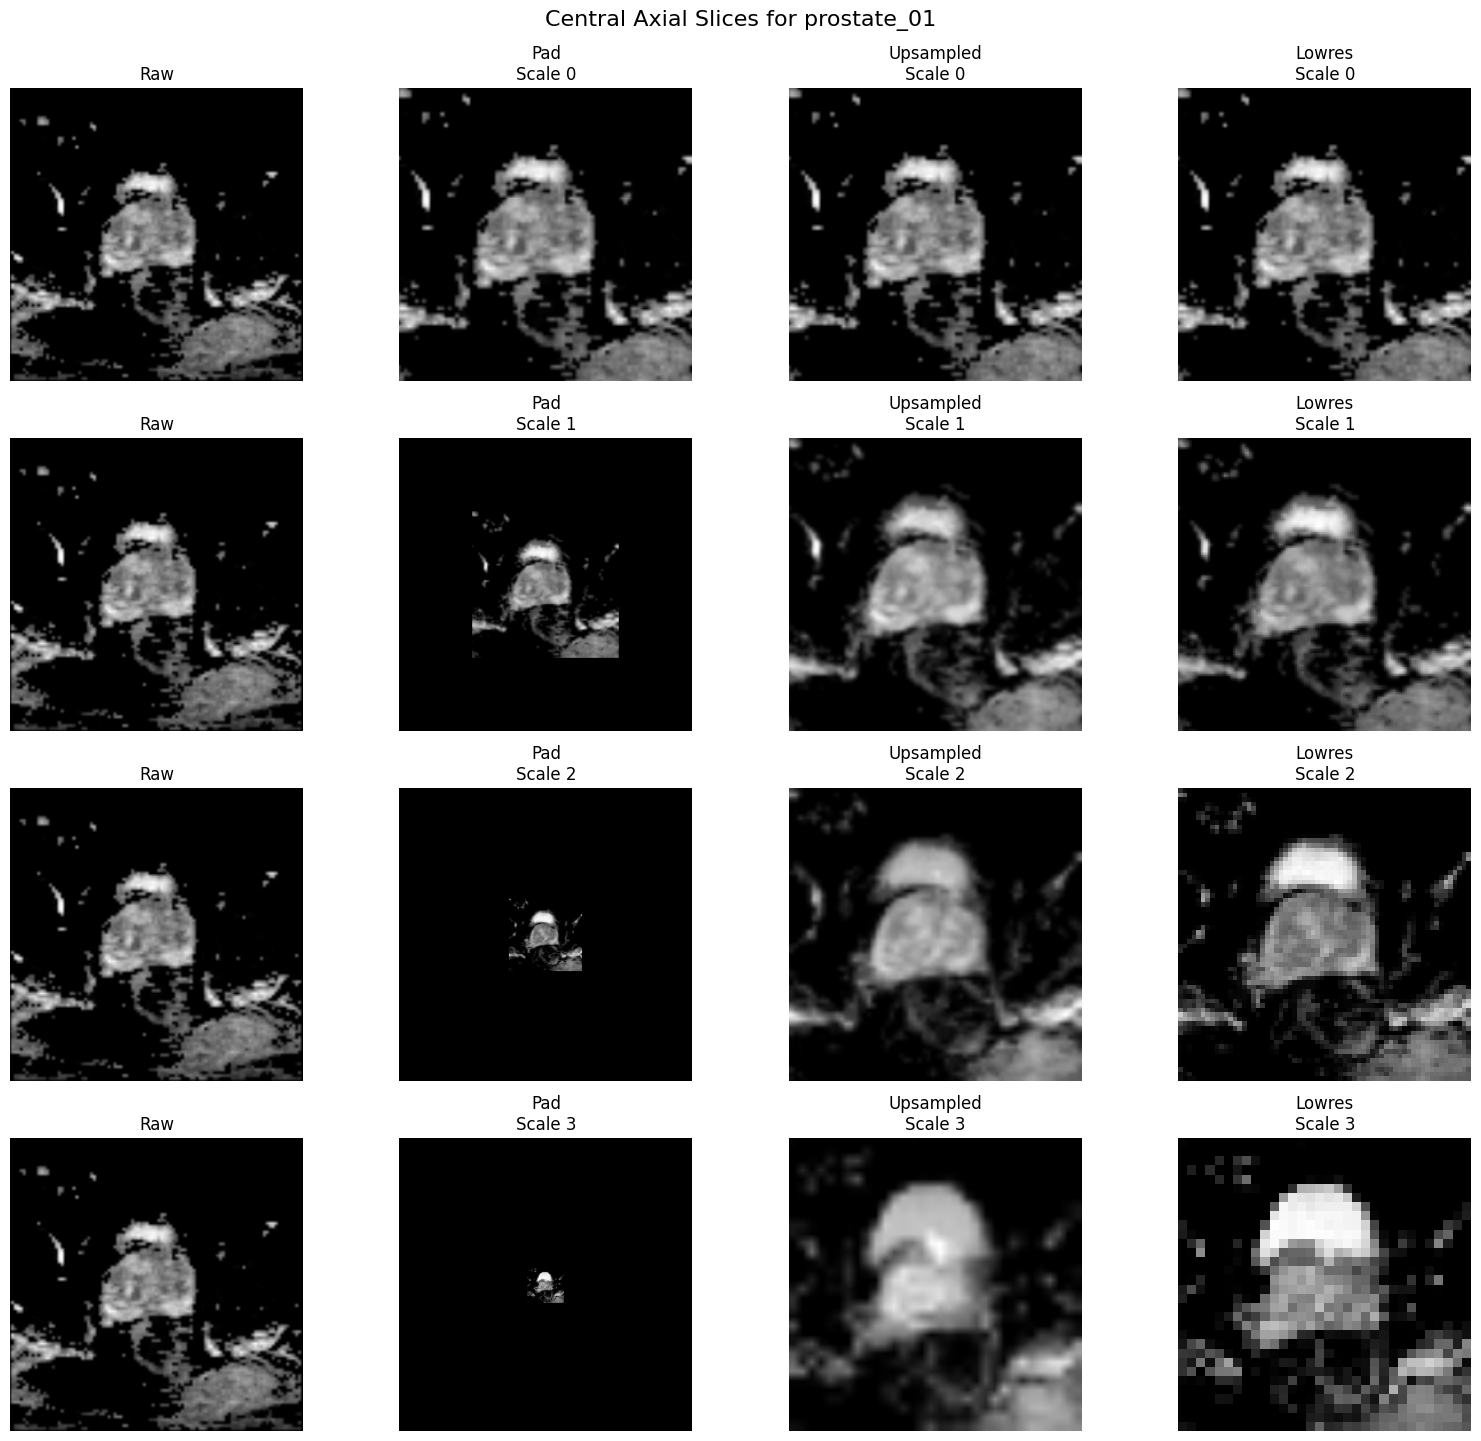

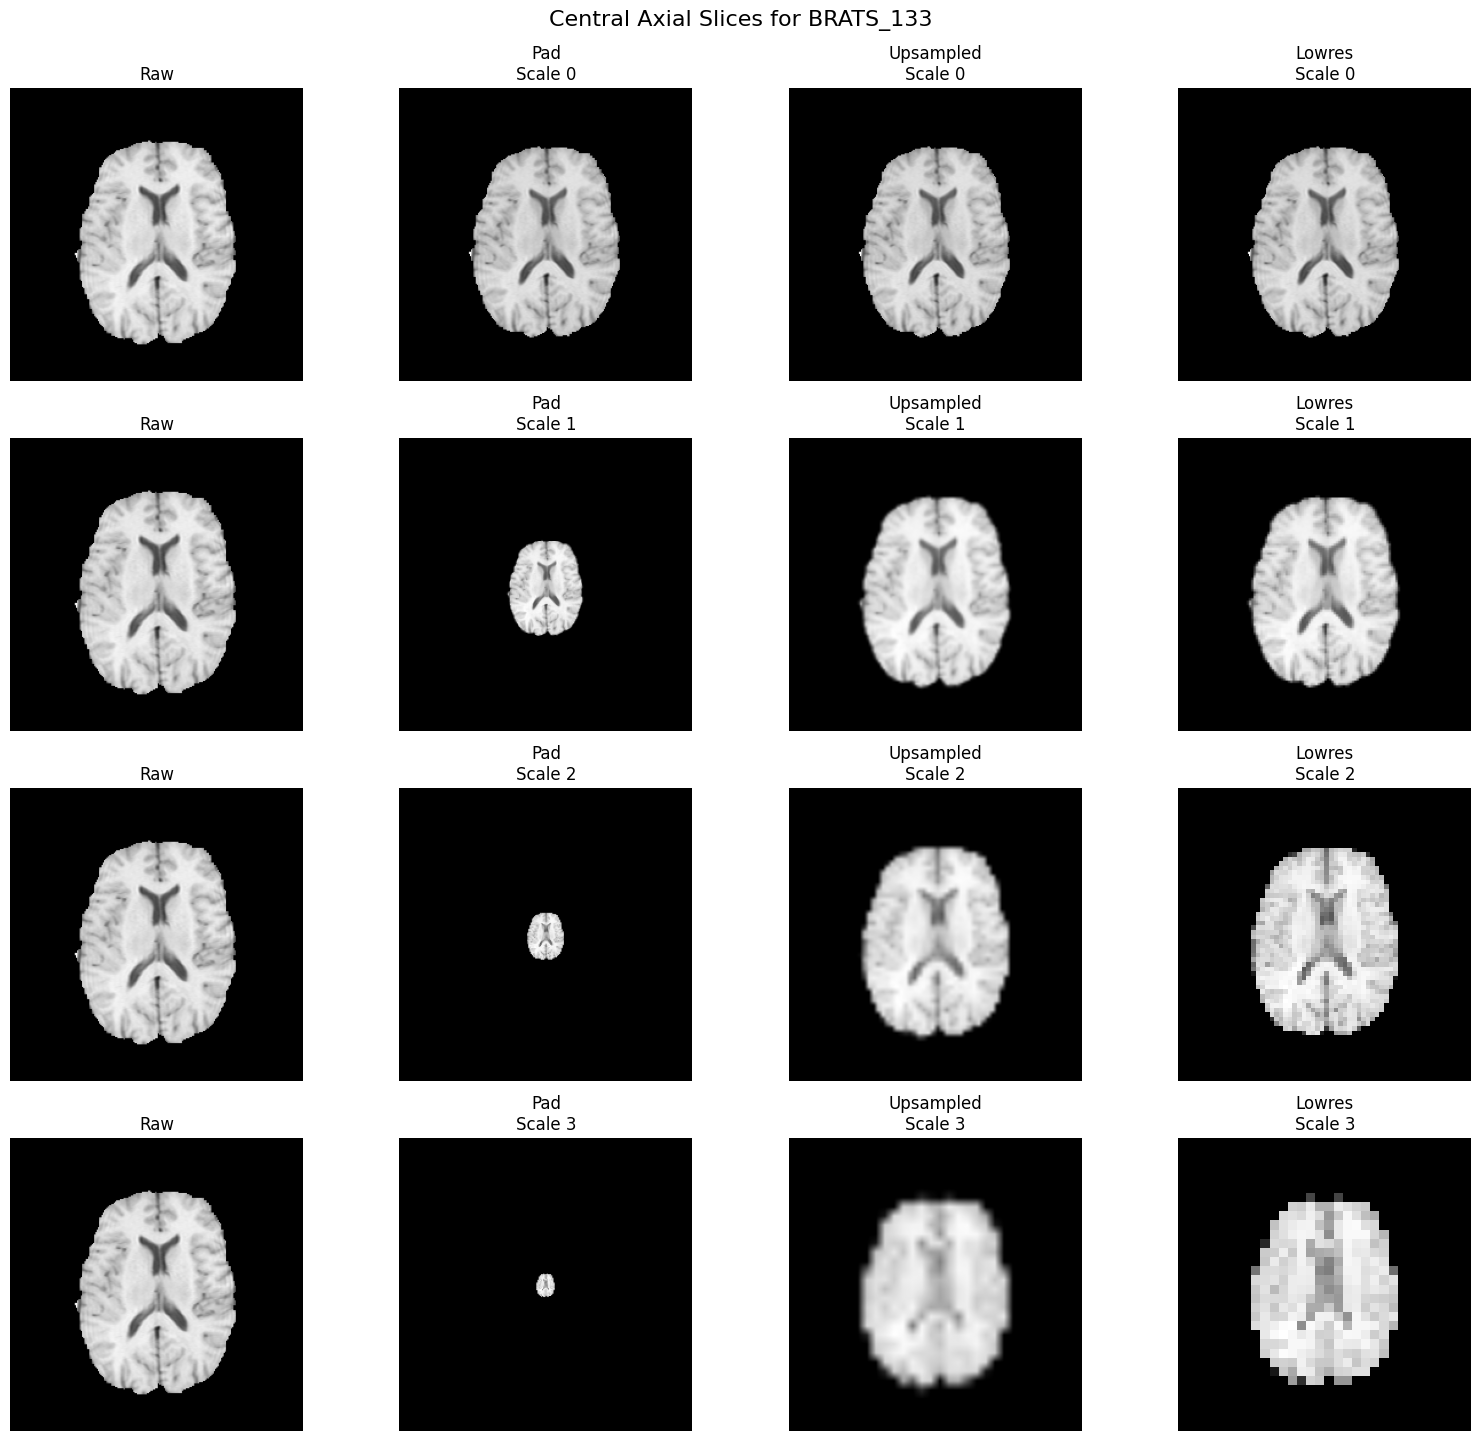

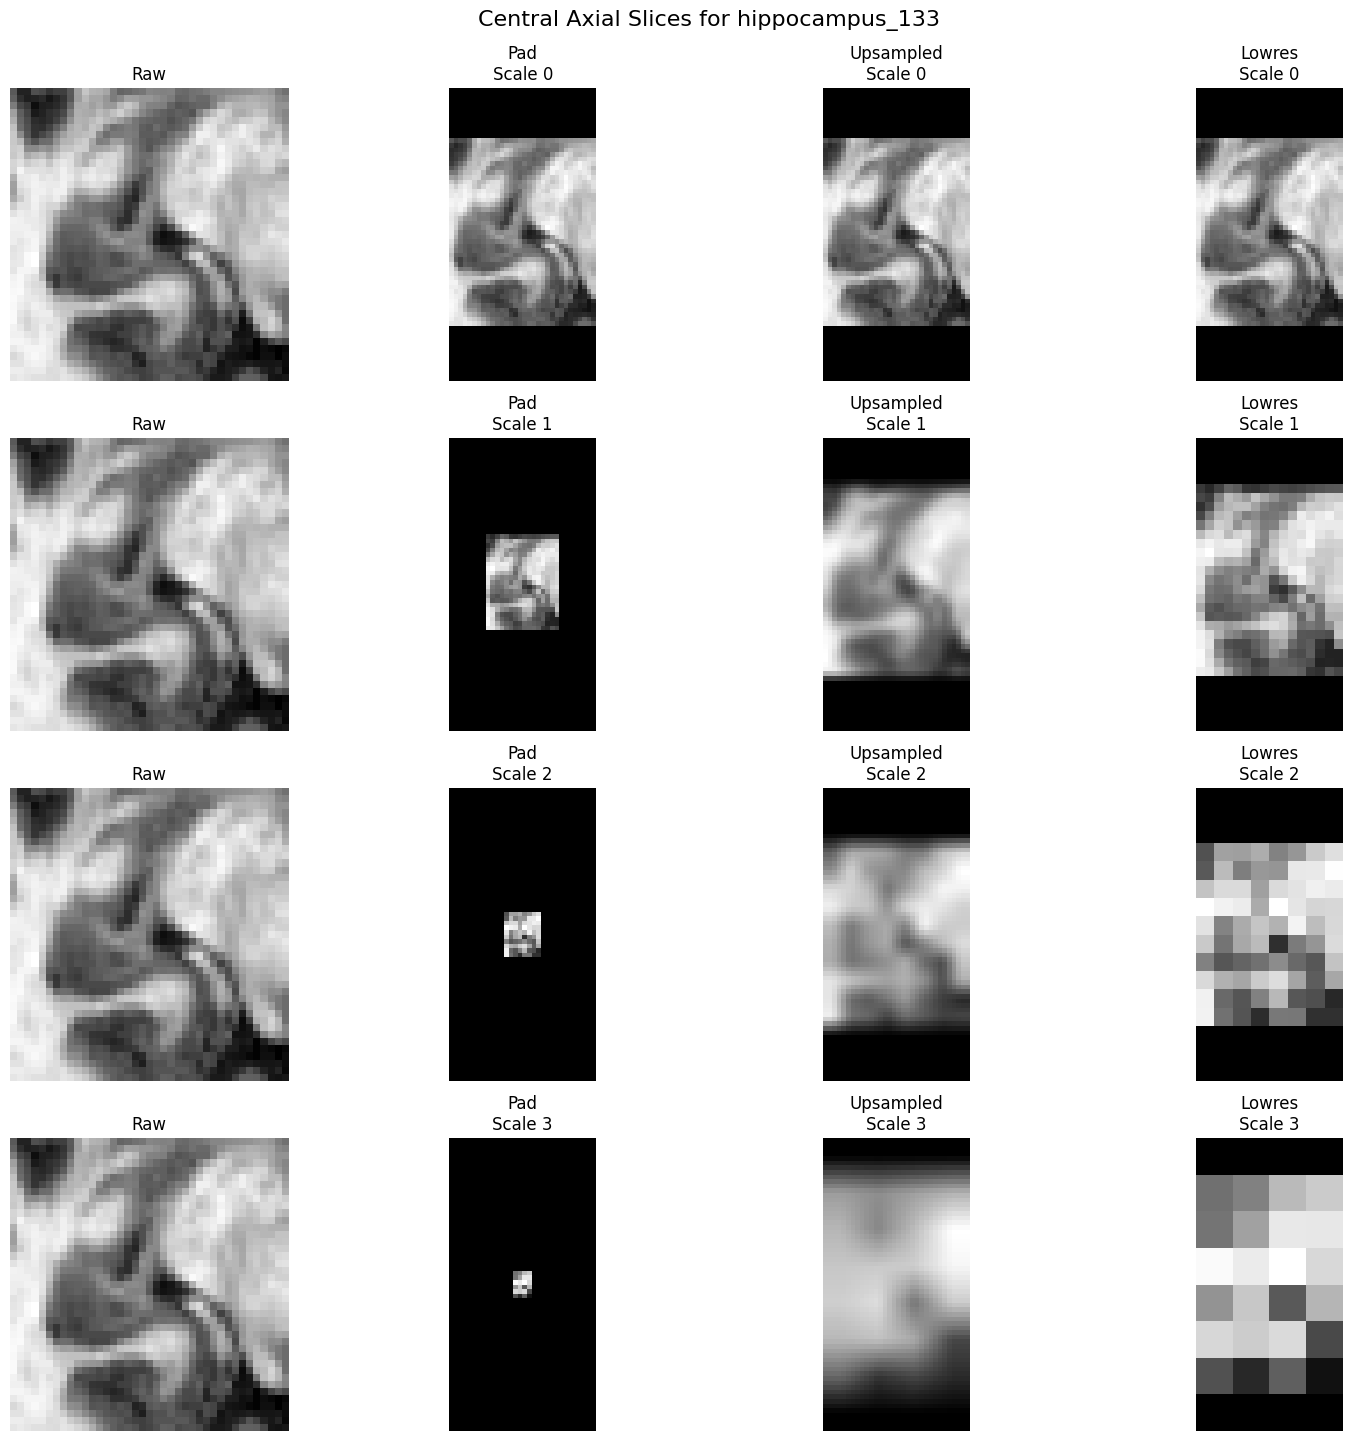

In [ ]:
import matplotlib.pyplot as plt
import os
import nibabel as nib

def show_images(base, image, depth=3):

	scales = list(range(depth+1))

	raw_path = f"{base}/fullres/raw/imagesTr/{image}.nii.gz" # Assuming .nii.gz, adjust if .nii
	pad_paths = [f"{base}/fullres/pad/scale{i}/imagesTr/{image}.nii.gz" for i in scales]
	upsampled_paths = [f"{base}/fullres/upsampled/scale{i}/imagesTr/{image}.nii.gz" for i in scales]
	lowres_paths = [f"{base}/lowres/downsampled/scale{i}/imagesTr/{image}.nii.gz" for i in scales]
	
	image_types_data = {
		"Raw": [raw_path] * len(scales), 
		"Pad": pad_paths,
		"Upsampled": upsampled_paths,
		"Lowres": lowres_paths
	}
	column_titles = ["Raw", "Pad", "Upsampled", "Lowres"]
	row_titles = [f'Scale {i}' for i in scales]


	# Helper function to load image and extract central axial slice
	def get_axial_slice(filepath, dataset_bool=False):
		if not os.path.exists(filepath):
			print(f"File not found: {filepath}")
			return None, f"File Not Found:\n{os.path.basename(filepath)}"

		try:
			img = nib.load(filepath)
			data = img.get_fdata()
			
			if data.ndim == 4:
			
				# we want the first central slice
				if data.shape[3] > 1:
					if dataset_bool:
						print(f"Warning: 4D data at {filepath} with shape {data.shape}. Taking first volume/channel.")
					data = data[:, :, :, 1]
				else:
					data = data[:, :, :, 0]  # If it's 4D but only one volume, take the first one
			
			if data.ndim != 3:
				err_msg = f"Unexpected data dim: {data.ndim}\n{os.path.basename(filepath)}"
				print(f"Error: {err_msg} for file {filepath}")
				return None, err_msBRATS_133g

			z_mid = data.shape[2] // 2
			axial_slice = data[:, :, z_mid]
			return axial_slice, None
		except Exception as e:
			err_msg = f"Error loading/slicing:\n{os.path.basename(filepath)}\n{str(e)}"
			print(f"Error processing {filepath}: {e}")
			return None, err_msg


	num_rows = len(scales)
	num_cols = len(column_titles)

	fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 3.5))


	for i, scale_val in enumerate(scales):  
		for j, type_name in enumerate(column_titles): 
			ax = axes[i][j]
			
			image_paths_for_type = image_types_data[type_name]
			current_path = image_paths_for_type[i] 

			slice_data, err_msg = get_axial_slice(current_path, True if i == 0 and j == 0 else False)

			if slice_data is not None:
				ax.imshow(slice_data.T, cmap='gray', origin='lower')
				plot_title = f"{type_name}"
				if type_name != "Raw":
					plot_title += f"\nScale {scale_val}"
				ax.set_title(plot_title)
			else:
				ax.text(0.5, 0.5, err_msg if err_msg else "Error", 
						ha='center', va='center', fontsize=8, color='red', wrap=True)
				
				plot_title = f"{type_name}"
				if type_name != "Raw":
					plot_title += f"\nScale {scale_val}"
				ax.set_title(plot_title, color='red')

			ax.axis('off')

	plt.tight_layout(pad=0.5, h_pad=1.0, w_pad=0.5) 
	plt.suptitle(f"Central Axial Slices for {image}", fontsize=16, y=1.02) 

	output_path = f"{image}_slices.svg"
	plt.savefig(output_path, format='svg', bbox_inches='tight')
	plt.show()


show_images("/home/si-hj/Desktop/datasets/Task05_Prostate_test1", "prostate_01") 
show_images("/home/si-hj/Desktop/datasets/Task01_BrainTumour_test1", "BRATS_133")
show_images("/home/si-hj/Desktop/datasets/Task04_Hippocampus_test1", "hippocampus_133") 

doesnt work below i think but error map is a cool idea

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.__config__ import show

import matplotlib.pyplot as plt
import numpy as np

def show_prediction(image, gt_mask, pred_mask, slice_idx=None, class_id=1):
    gt_binary = (gt_mask == class_id)
    pred_binary = (pred_mask == class_id)

    if slice_idx is None:
        z_coords = np.where(gt_binary)[0]
        slice_idx = z_coords[len(z_coords)//2] if len(z_coords) > 0 else gt_mask.shape[0] // 2

    plt.figure(figsize=(16, 4))

    plt.subplot(1, 4, 1)
    plt.imshow(image[slice_idx], cmap='gray')
    plt.title("MRI Slice")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(gt_binary[slice_idx], cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(pred_binary[slice_idx], cmap='gray')
    plt.title("Prediction")
    plt.axis('off')

    plt.subplot(1, 4, 4)
    error_map = np.logical_xor(gt_binary[slice_idx], pred_binary[slice_idx])
    plt.imshow(error_map, cmap='Reds')
    plt.title("Error Map")
    plt.axis('off')

    plt.suptitle(f"Class {class_id} - Slice {slice_idx}", fontsize=14)
    plt.tight_layout()
    plt.show()


show_prediction(image_np, gt_np, pred_np, class_id=1)


NameError: name 'image_np' is not defined